# Advanced Feature Overview
To give a full demonstration of the features of mlwhatif, we will use a relatively complex pipeline to classify helpful Amazon reviews. The pipeline is taken from the [argusyes](https://github.com/schelterlabs/arguseyes) project. The pipeline is implemented using native constructs from the popular pandas and scikit-learn libraries.

Let us start by looking at the pipeline source code.

In [1]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython
import os
from mlwhatif.utils import get_project_root

DEMO_PY = os.path.join(str(get_project_root()), "demo", "advanced_features", "reviews.py")

with open(DEMO_PY) as pipline_file:
    code = pipline_file.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

To now conduct our what-if analyses, we do not need to rewrite this pipeline file, we can use it directly as input for mlwhatif. Now, let us look at different analyses already implemented in mlwhatif.

## Data Corruption
Here, we test the robustness of our pipeline against different data quality errors. For each column, we can specify the type of errors to introduce. We can also specify different fractions of rows to corrupt. By default, the corruptions are only added to the test branch of the pipeline. Optionally, the analysis allows introducing the same corruption also to the train branch, to see if training the model with data with these expected types of errors helps when encountering them at inference time.

In [2]:
from mlwhatif import PipelineAnalyzer
from mlwhatif.analysis._data_corruption import DataCorruption, CorruptionType
import warnings
warnings.filterwarnings('ignore')  # To keep the output readable


robustness = DataCorruption([('vine', CorruptionType.CATEGORICAL_SHIFT),
                             ('review_body', CorruptionType.BROKEN_CHARACTERS),
                             ('category', CorruptionType.CATEGORICAL_SHIFT),
                             ('total_votes', CorruptionType.MISSING_VALUES),
                             ('star_rating', CorruptionType.SCALING)],
                             corruption_percentages=[0.33, 0.66, 1.0])

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(robustness) \
    .execute()

robustness_report = analysis_result.analysis_to_result_reports[robustness]

2023-02-27 16:20:22 INFO  Running instrumented original pipeline...
2023-02-27 16:20:22 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2023-02-27 16:20:23 INFO  ---RUNTIME: Importing and monkey-patching took 225.53515434265137 ms
2023-02-27 16:20:31 INFO  ---RUNTIME: Original pipeline execution took 7893.7437534332275 ms (excluding imports and monkey-patching)
2023-02-27 16:20:31 INFO  Starting execution of 1 what-if analyses...
2023-02-27 16:20:31 INFO  Start plan generation for analysis DataCorruption...
2023-02-27 16:20:31 INFO  ---RUNTIME: Plan generation took 0.5130767822265625 ms
2023-02-27 16:20:31 INFO  Estimated runtime of original DAG is 7703.157424926758ms
2023-02-27 16:20:31 INFO  Performing Multi-Query Optimization
2023-02-27 16:20:31 INFO  Estimated unoptimized what-if runtime is 115547.36137390137ms
2023-02-27 16:20:31 INFO  Estimated optimised what-if runtime is 12072.322130203247ms
2023-02-27 16:20:31 INFO  Est

Let us start by looking at the report generated by the analysis. Each row in this pandas `DataFrame` corresponds to one pipeline variant executed by mlwhatif. In the first report column, we see the pipeline column that was corrupted in the tested pipeline variant. In the second report column, we see the fraction of currupted values in the pipeline column. In the third column, we see the utility score of that variant.

In the first row, we see the output from the original pipeline.

Here, find that our pipeline is relatively robust against the tested data quality issues, as long as they appear in one column at a time. The lowest utility score we see is for high fractions of missing values in the `star_rating` column. In the real world, this could be a candidate for data quality monitoring when deploying the pipeline in production.

In [3]:
robustness_report

column  corruption_percentage  accuracy_score_corrupt_test_only_L109
0          None                    NaN                               0.883483
1          vine                   0.33                               0.880205
2          vine                   0.66                               0.880205
3          vine                   1.00                               0.880205
4   review_body                   0.33                               0.876116
5   review_body                   0.66                               0.870144
6   review_body                   1.00                               0.865762
7      category                   0.33                               0.880205
8      category                   0.66                               0.880205
9      category                   1.00                               0.880205
10  total_votes                   0.33                               0.884100
11  total_votes                   0.66                               0.887053
12  total_votes                   1.00                               0.891402
13  star_rating                   0.33                               0.868618
14  star_rating                   0.66                               0.855344
15  star_rating                   1.00                               0.842848

## Permutation Feature Importance
Next, we try looking at the importance of different features. By default, it will test the importance of all columns, but it is also possible to limit this to a subset of columns.

In [4]:
from mlwhatif.analysis._permutation_feature_importance import PermutationFeatureImportance

importance = PermutationFeatureImportance()

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(importance) \
    .execute()

importance_report = analysis_result.analysis_to_result_reports[importance]

2023-02-27 16:20:49 INFO  Running instrumented original pipeline...
2023-02-27 16:20:49 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2023-02-27 16:20:49 INFO  ---RUNTIME: Importing and monkey-patching took 9.613990783691406 ms
2023-02-27 16:20:55 INFO  ---RUNTIME: Original pipeline execution took 6719.825983047485 ms (excluding imports and monkey-patching)
2023-02-27 16:20:55 INFO  Starting execution of 1 what-if analyses...
2023-02-27 16:20:55 INFO  Start plan generation for analysis PermutationFeatureImportance...
2023-02-27 16:20:55 INFO  ---RUNTIME: Plan generation took 0.31685829162597656 ms
2023-02-27 16:20:55 INFO  Estimated runtime of original DAG is 6585.862159729004ms
2023-02-27 16:20:55 INFO  Performing Multi-Query Optimization
2023-02-27 16:20:55 INFO  Estimated unoptimized what-if runtime is 32929.31079864502ms
2023-02-27 16:20:55 INFO  Estimated optimised what-if runtime is 7842.390060424805ms
2023-02-27 16:20:5

Now let us look at the report. The output follows the same structure all our analyses have, as seen the data corruption example. We see that the model does not rely on any single feature too much, but that `total_votes` seems to be the most important single feature.

In [5]:
importance_report

column  accuracy_score_L109
0         None             0.883483
1  total_votes             0.734770
2  star_rating             0.875434
3     category             0.876375
4  review_body             0.868878
5         vine             0.876375

## Operator Impact
Next, we want to know the impact of different preprocessing operations in our pipeline. Currently, it tests the impact of both transformer and filter preprocessing operators.

In [6]:
from mlwhatif.analysis._operator_impact import OperatorImpact

preproc = OperatorImpact(test_selections=True)

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(preproc) \
    .execute()

preproc_report = analysis_result.analysis_to_result_reports[preproc]

2023-02-27 16:21:06 INFO  Running instrumented original pipeline...
2023-02-27 16:21:06 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2023-02-27 16:21:06 INFO  ---RUNTIME: Importing and monkey-patching took 13.360738754272461 ms
2023-02-27 16:21:13 INFO  ---RUNTIME: Original pipeline execution took 6529.502391815186 ms (excluding imports and monkey-patching)
2023-02-27 16:21:13 INFO  Starting execution of 1 what-if analyses...
2023-02-27 16:21:13 INFO  Start plan generation for analysis OperatorImpact...
2023-02-27 16:21:13 INFO  ---RUNTIME: Plan generation took 10.891914367675781 ms
2023-02-27 16:21:13 INFO  Estimated runtime of original DAG is 6385.399103164673ms
2023-02-27 16:21:13 INFO  Performing Multi-Query Optimization
2023-02-27 16:21:13 INFO  Estimated unoptimized what-if runtime is 33173.53346253712ms
2023-02-27 16:21:13 INFO  Estimated optimised what-if runtime is 13316.966569716973ms
2023-02-27 16:21:13 INFO  Estim

We look at the results and find that none of the preprocessing steps we tested the impact of has a large impact. If, for example, one of the filters would cause a noticable change, we would need to worry that the selected data subset is not representative of the dataset as a whole.

In [7]:
preproc_report

operator_type  operator_lineno  \
0          None              NaN   
1   Transformer             65.0   
2   Transformer             73.0   
3   Transformer             73.0   
4     Selection             37.0   
5     Selection             43.0   

                                       operator_code  \
0                                               None   
1                                     RobustScaler()   
2               FunctionTransformer(another_imputer)   
3               FunctionTransformer(another_imputer)   
4  reviews[reviews['review_date'] >= start_date.s...   
5  products_with_categories[\n        products_wi...   

        strategy_description  accuracy_score_L109  
0                       None             0.883483  
1                passthrough             0.887508  
2  replace nan with constant             0.884197  
3  replace nan with constant             0.884197  
4            drop the filter             0.878031  
5            drop the filter             0.882806

## Data Cleaning
Next, we want to know the impact of additional cleaning operations. For each column, we can specify which types of errors we expect, and mlwhatif will then automatically try all cleaning techniques it knows for that kind of error.

In [8]:
from mlwhatif.analysis._data_cleaning import DataCleaning, ErrorType

cleanlearn = DataCleaning({'category': ErrorType.CAT_MISSING_VALUES,
                           'vine': ErrorType.CAT_MISSING_VALUES,
                           'star_rating': ErrorType.NUM_MISSING_VALUES,
                           'total_votes': ErrorType.OUTLIERS,
                           'review_id': ErrorType.DUPLICATES,
                           None: ErrorType.MISLABEL
                         })

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(cleanlearn) \
    .execute()

cleanlearn_report = analysis_result.analysis_to_result_reports[cleanlearn]

2023-02-27 16:21:30 INFO  Running instrumented original pipeline...
2023-02-27 16:21:30 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2023-02-27 16:21:30 INFO  ---RUNTIME: Importing and monkey-patching took 7.830142974853516 ms
2023-02-27 16:21:35 INFO  ---RUNTIME: Original pipeline execution took 4560.765027999878 ms (excluding imports and monkey-patching)
2023-02-27 16:21:35 INFO  Starting execution of 1 what-if analyses...
2023-02-27 16:21:35 INFO  Start plan generation for analysis DataCleaning...
2023-02-27 16:21:35 INFO  ---RUNTIME: Plan generation took 0.8349418640136719 ms
2023-02-27 16:21:35 INFO  Estimated runtime of original DAG is 4456.615209579468ms
2023-02-27 16:21:35 INFO  Performing Multi-Query Optimization
2023-02-27 16:21:35 INFO  Estimated unoptimized what-if runtime is 98582.2582244873ms
2023-02-27 16:21:35 INFO  Estimated optimised what-if runtime is 14912.702798843384ms
2023-02-27 16:21:35 INFO  Estimated

Let us look at the output of the data cleaning analysis. We find that some of the outlier detection methods actually decrease the performance of our pipeline. Here, the only data cleaning option that yields in a noticable improvement, is the [cleanlab](https://github.com/cleanlab/cleanlab) label cleaning technique. Maybe we should take a close look at our labels and perform some more label cleaning.

In [9]:
cleanlearn_report

corrupted_column                       error          cleaning_method  \
0              None                        None                     None   
1          category  categorical missing values                   delete   
2          category  categorical missing values          impute_cat_mode   
3          category  categorical missing values         impute_cat_dummy   
4              vine  categorical missing values                   delete   
5              vine  categorical missing values          impute_cat_mode   
6              vine  categorical missing values         impute_cat_dummy   
7       star_rating    numerical missing values                   delete   
8       star_rating    numerical missing values        impute_num_median   
9       star_rating    numerical missing values          impute_num_mean   
10      star_rating    numerical missing values          impute_num_mode   
11      total_votes                    outliers     clean_SD_impute_mean   
12      total_votes                    outliers   clean_SD_impute_median   
13      total_votes                    outliers     clean_SD_impute_mode   
14      total_votes                    outliers    clean_IQR_impute_mean   
15      total_votes                    outliers  clean_IQR_impute_median   
16      total_votes                    outliers    clean_IQR_impute_mode   
17      total_votes                    outliers     clean_IF_impute_mean   
18      total_votes                    outliers   clean_IF_impute_median   
19      total_votes                    outliers     clean_IF_impute_mode   
20        review_id                  duplicates                   delete   
21             None                    mislabel                 cleanlab   
22             None                    mislabel                  shapley   

    accuracy_score_L109  
0              0.883483  
1              0.878972  
2              0.871799  
3              0.873552  
4              0.880465  
5              0.876603  
6              0.877219  
7              0.873032  
8              0.842394  
9              0.858622  
10             0.845834  
11             0.827269  
12             0.836812  
13             0.844568  
14             0.890396  
15             0.873487  
16             0.861900  
17             0.870631  
18             0.846321  
19             0.868586  
20             0.884295  
21             0.896336  
22             0.879881

## Advanced features
Here, we repeatedly called mlwhatif on the pipeline source code file. Each time, we re-execute the original pipeline once to get the utility score for the pipeline variant without changes, and also for extracting the re-executable pipeline plan mlwhatif uses internally. Instead, we can directly execute our pipeline with mlwhatif once, and then reuse those results. We can even just always do this during pipeline development, if we know that we might want to run what-if analyses with mlwhatif afterward.

In [10]:
original_pipeline_info = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .execute() \
    .dag_extraction_info

2023-02-27 16:21:58 INFO  Running instrumented original pipeline...
2023-02-27 16:21:58 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2023-02-27 16:21:58 INFO  ---RUNTIME: Importing and monkey-patching took 8.762121200561523 ms
2023-02-27 16:22:02 INFO  ---RUNTIME: Original pipeline execution took 4369.9657917022705 ms (excluding imports and monkey-patching)
2023-02-27 16:22:02 INFO  Starting execution of 0 what-if analyses...
2023-02-27 16:22:02 INFO  Estimated runtime of original DAG is 4265.347957611084ms
2023-02-27 16:22:02 INFO  Performing Multi-Query Optimization
2023-02-27 16:22:02 INFO  Estimated unoptimized what-if runtime is 0ms
2023-02-27 16:22:02 INFO  Estimated optimised what-if runtime is 0ms
2023-02-27 16:22:02 INFO  Estimated optimisation runtime saving is 0ms
2023-02-27 16:22:02 INFO  ---RUNTIME: Multi-Query Optimization took 3.414154052734375 ms
2023-02-27 16:22:02 INFO  Executing generated plans
2023-02-27 1

Now that we have this extracted plan, we can directly use it for what-if analysis, and the execution will be faster.

In [11]:
_ = PipelineAnalyzer \
    .on_previously_extracted_pipeline(original_pipeline_info) \
    .add_what_if_analysis(PermutationFeatureImportance()) \
    .execute()

2023-02-27 16:22:02 INFO  Reusing DAG extraction results results from previously instrumented pipeline...
2023-02-27 16:22:02 INFO  Starting execution of 1 what-if analyses...
2023-02-27 16:22:02 INFO  Start plan generation for analysis PermutationFeatureImportance...
2023-02-27 16:22:02 INFO  ---RUNTIME: Plan generation took 0.2460479736328125 ms
2023-02-27 16:22:02 INFO  Estimated runtime of original DAG is 4265.347957611084ms
2023-02-27 16:22:02 INFO  Performing Multi-Query Optimization
2023-02-27 16:22:02 INFO  Estimated unoptimized what-if runtime is 21326.73978805542ms
2023-02-27 16:22:02 INFO  Estimated optimised what-if runtime is 5003.306150436401ms
2023-02-27 16:22:02 INFO  Estimated optimisation runtime saving is 16323.433637619019ms
2023-02-27 16:22:02 INFO  ---RUNTIME: Multi-Query Optimization took 19.050121307373047 ms
2023-02-27 16:22:02 INFO  Executing generated plans
2023-02-27 16:22:07 INFO  ---RUNTIME: Execution took 5341.136932373047 ms
2023-02-27 16:22:07 INFO  Don

This is especially useful when using the runtime estimation feature to tune the what-if analysis workload size in advance before triggering execution.

Example: How expensive would the data corruption analysis be, when also adding corruptions to the train-side?

After seeing the estimates, we know that we can try the effect of corruptions on the train-side without waiting too long.

In [12]:
robustness_with_train = DataCorruption([('vine', CorruptionType.CATEGORICAL_SHIFT),
                                        ('review_body', CorruptionType.BROKEN_CHARACTERS),
                                        ('category', CorruptionType.CATEGORICAL_SHIFT),
                                        ('total_votes', CorruptionType.MISSING_VALUES),
                                        ('star_rating', CorruptionType.SCALING)],
                                        corruption_percentages=[0.33, 0.66, 1.0],
                                       also_corrupt_train=True)

import logging
logging.disable(logging.CRITICAL) # Disable logging to have readable print output

print("With train corruptions")
PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(robustness_with_train) \
    .estimate() \
    .print_estimate()

print("Without train corruptions")
PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(robustness) \
    .estimate() \
    .print_estimate()

With train corruptions
Estimated runtime is 15362.65230178833ms.
Without train corruptions
Estimated runtime is 8032.1149826049805ms.


## A small peak under the hood
Internally, mlwhatif extracts a re-executable plan of the original pipeline and uses multi-query optimization to optimize the execution of what-if analyses. Let us take a look at what this looks like for a simple example.
We will try to keep the what-if analysis very simple for readability.

In [13]:
from IPython.core.display import Image
EXAMPLE_ORIGINAL_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "example-orig")
EXAMPLE_OPTIMIZED_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "example-optimised")
simple_analysis = DataCorruption([('total_votes', CorruptionType.MISSING_VALUES),
                                  ('star_rating', CorruptionType.SCALING)],
                                 corruption_percentages=[0.8])

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(simple_analysis) \
    .execute()
analysis_result.save_original_dag_to_path(EXAMPLE_ORIGINAL_PLAN_PATH)
analysis_result.save_optimised_what_if_dags_to_path(EXAMPLE_OPTIMIZED_PLAN_PATH)

The original pipeline plan extracted from the source code.

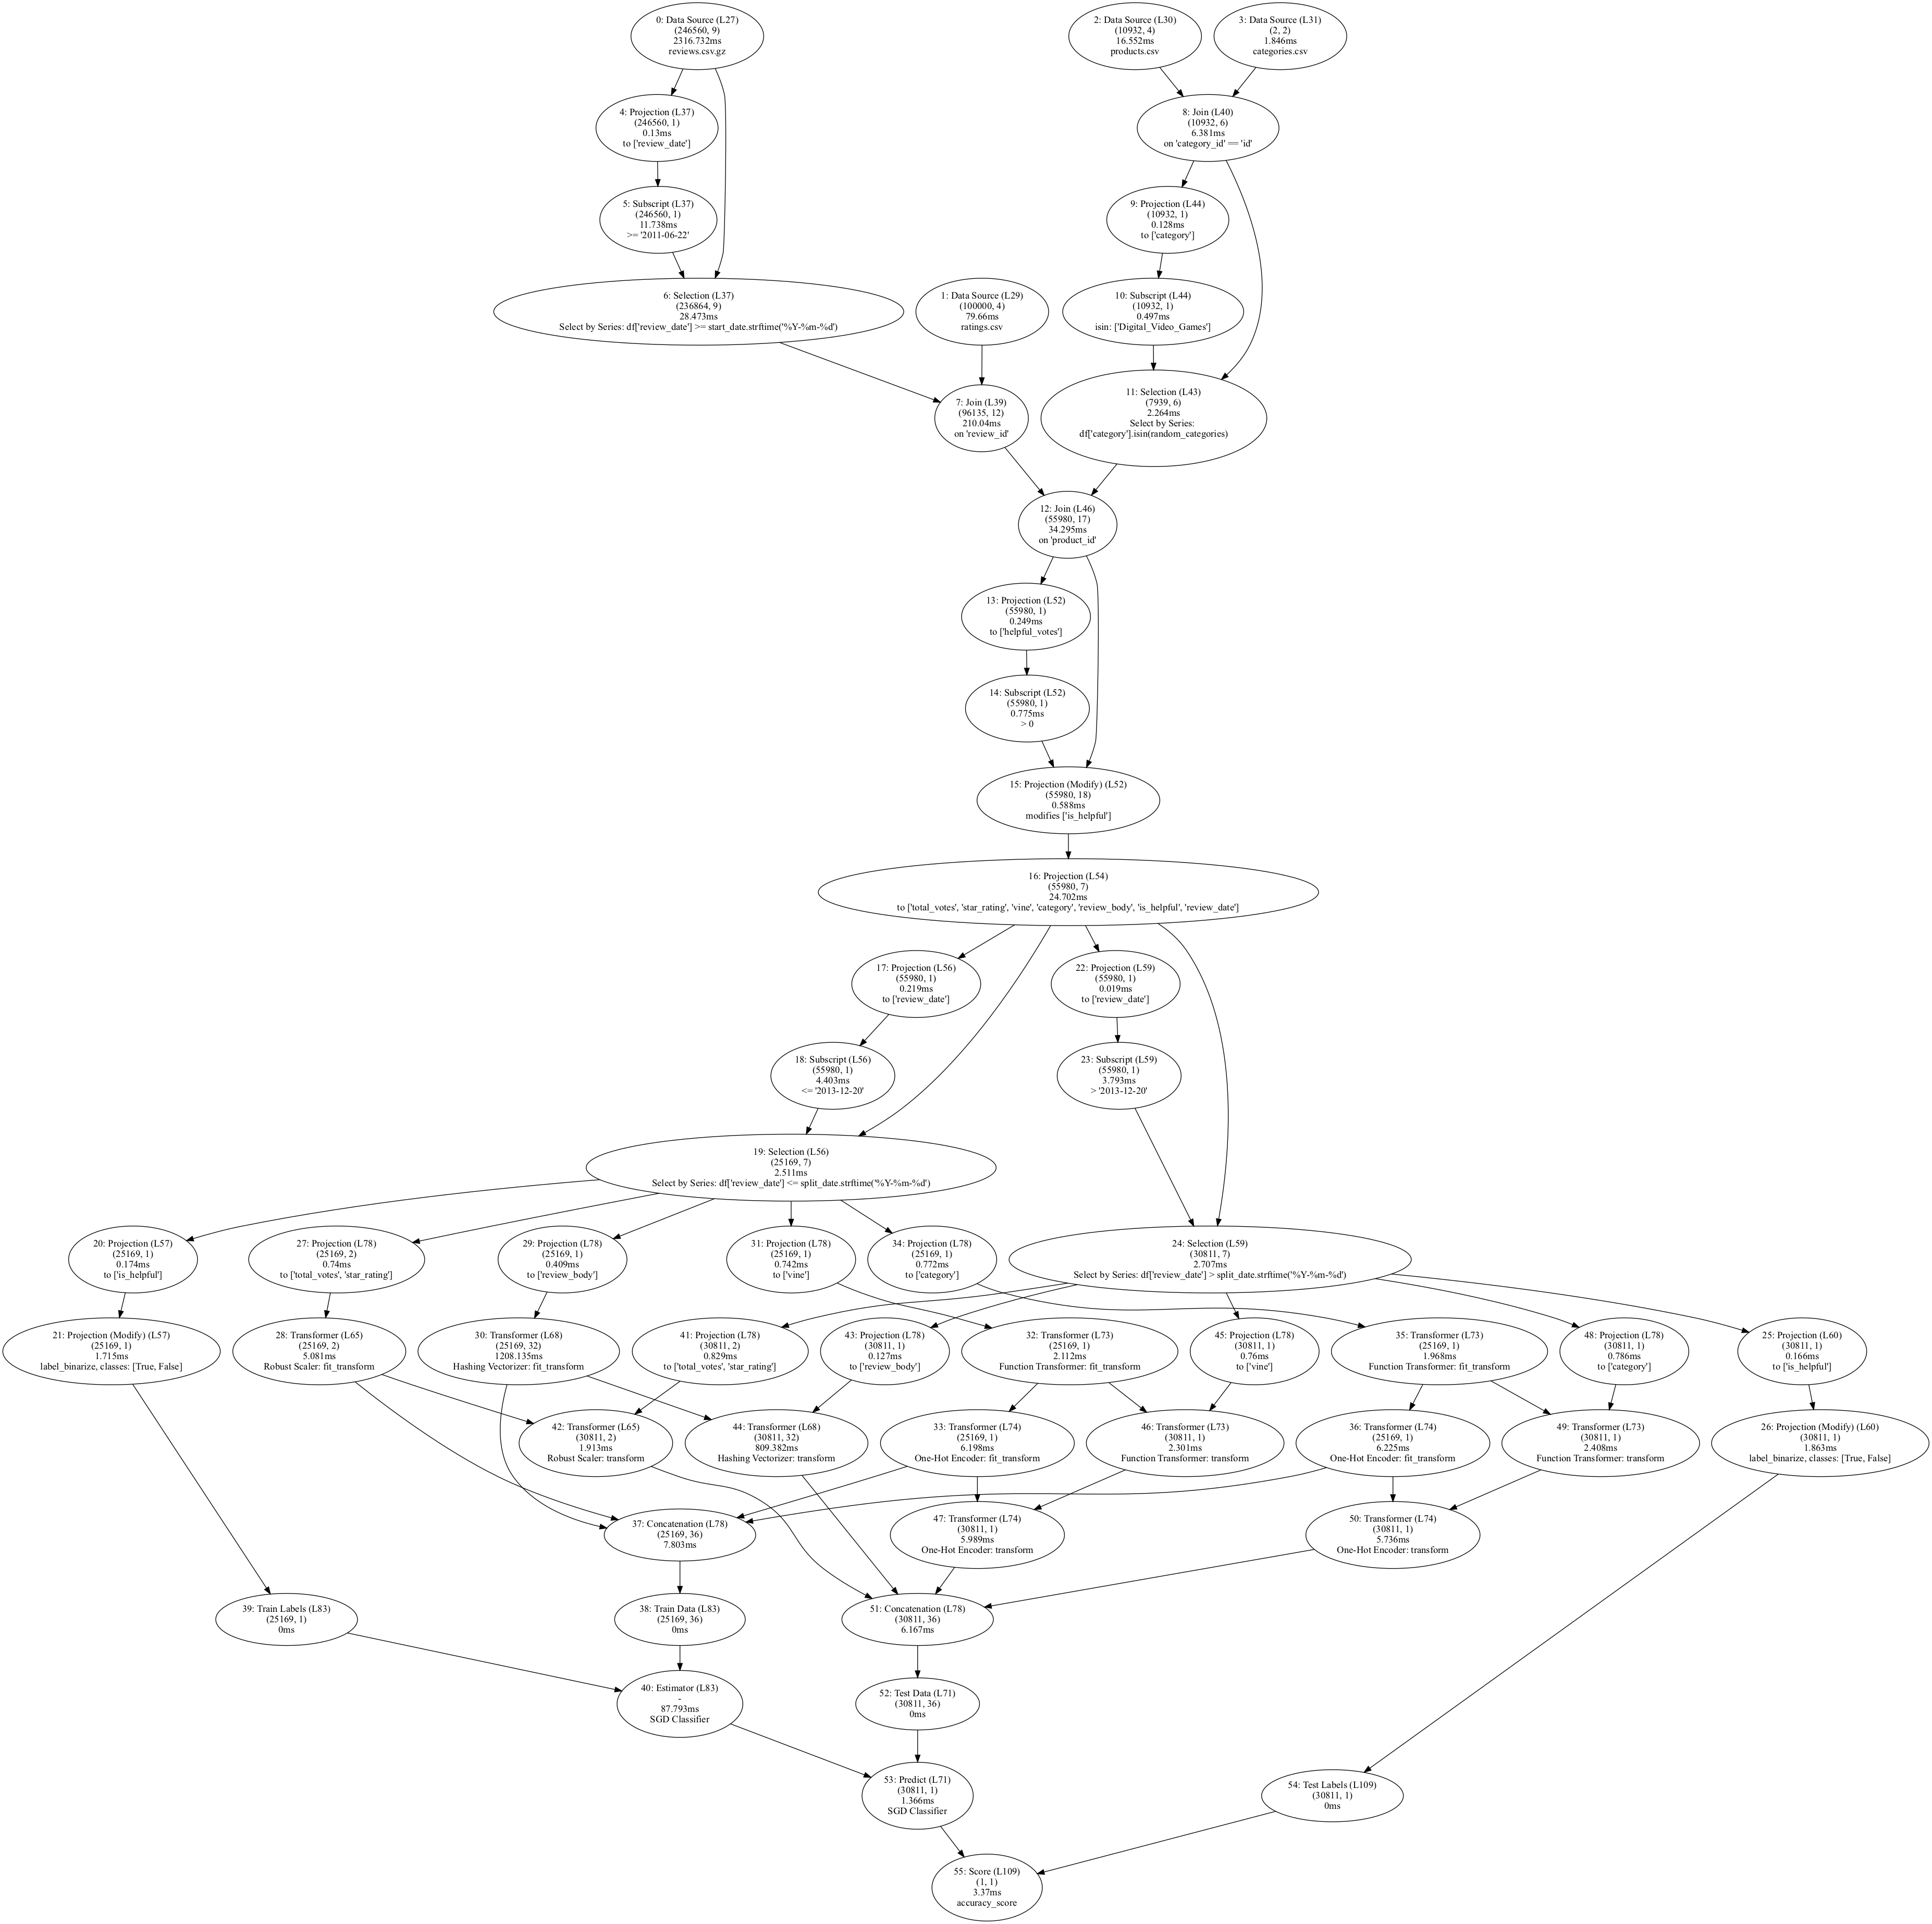

In [14]:
Image(filename=f"{EXAMPLE_ORIGINAL_PLAN_PATH}.png")

The optimised plan. Note how similar it is to the original plan thanks to multi-query optimisation.

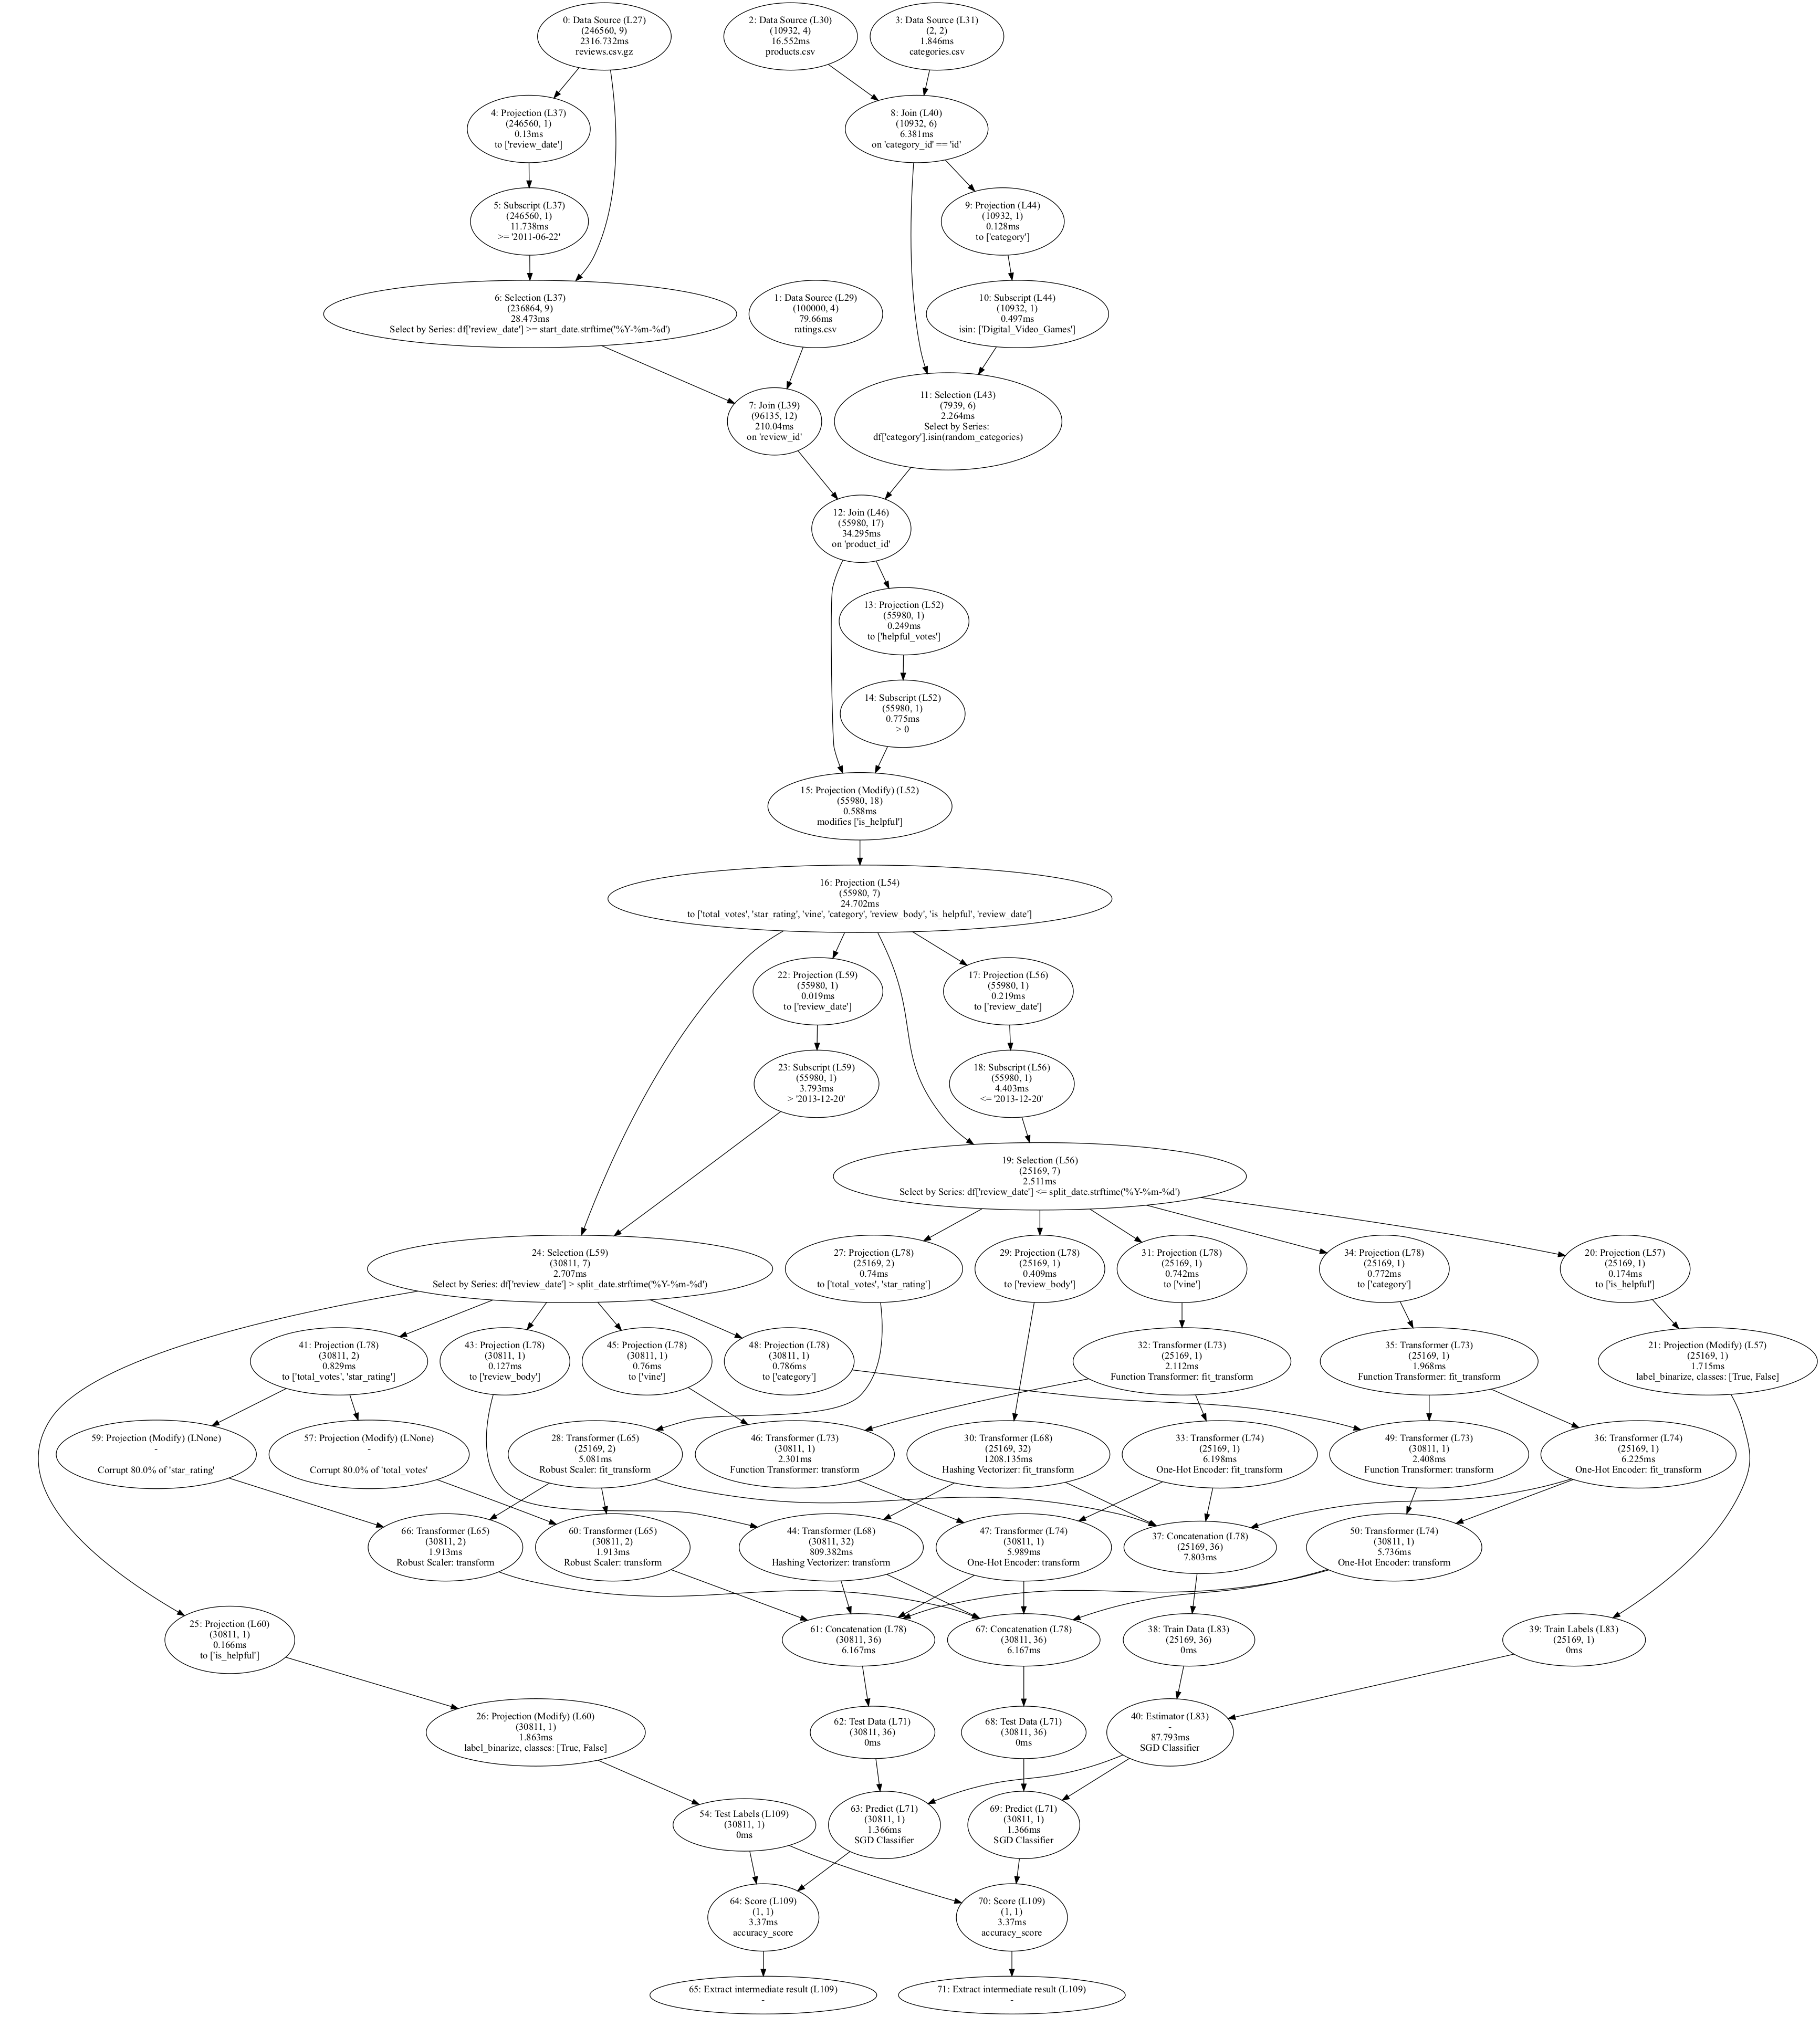

In [15]:
Image(filename=f"{EXAMPLE_OPTIMIZED_PLAN_PATH}.png")

However, these plans can become very complex quickly.

In [16]:
EXAMPLE_COMPLEX_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "example-complex")
PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(cleanlearn) \
    .estimate() \
    .save_optimised_what_if_dags_to_path(EXAMPLE_COMPLEX_PATH)
# Saving the large plan as image and loading it takes some time
Image(filename=f"{EXAMPLE_COMPLEX_PATH}.png")